In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import sys
import matplotlib.pyplot as plt
import resource
from IPython.display import display

from ggqpy import construct_Chevyshev_quadratures
from ggqpy.functionfamiliy import Interval
from ggqpy.testproblems import example_problem, gen_poly_and_sing
from ggqpy.discretize import Discretizer#
from ggqpy.compress import compress_sequence_of_functions, visualise_diagonal_dropoff
from ggqpy.optimize import QuadOptimizer

resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x100000)

In [2]:
eps_disc = 1e-10
eps_comp = 1e2*eps_disc
eps_quad = 1e-2
I = Interval(1e-9,1)
seed = 0

In [3]:
rng_gen = np.random.default_rng(seed)
F = example_problem(I, number_of_functions = 100, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()

Example function from function space


-1.53219353154532*x**10 - 2.94044299940431*x**9 + 3.96813242673358*x**8 + 3.97565669832997*x**7 - 3.84921371821007*x**6 + 2.88993907759461*x**5 + 5.01771204813693*x**4 - 3.60523555951368*x**3 - 8.17617971027895*x**2 - 1.70069868663042*x + 5.38473549269301 + 0.313649206818182/x

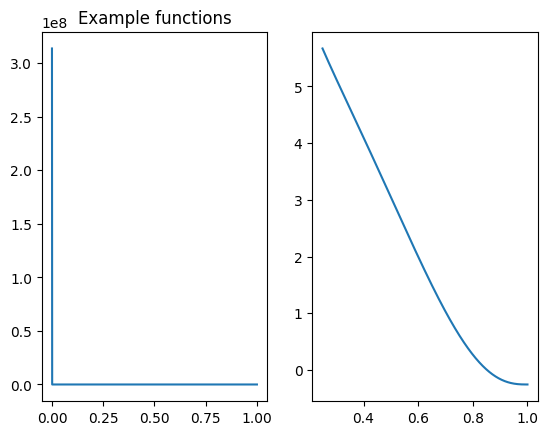

In [4]:
print("Example function from function space")
display(ex_f_expr)
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2);
xx2 = np.linspace((I.a + I.b)/4,I.b,1000)
plt.plot(xx2,ex_f(xx2));

Discretization and compression

In [5]:
k = 30
disc = Discretizer(eps_disc,min_length=1e-7)
x_disc, w_disc, endpoints, intervals = disc.adaptive_discretization(F)
U_disc, A, rank, u_list = compress_sequence_of_functions(F, x_disc, w_disc, eps_comp, k, intervals)

Functions before compression: 100
Functions after compression: 12


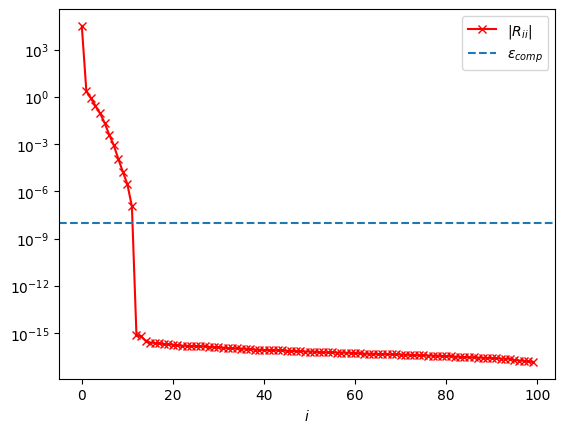

In [6]:
print("Functions before compression:", len(F.functions))
print("Functions after compression:", len(u_list))
visualise_diagonal_dropoff(A, eps_comp)

Chebyshev Rule

In [7]:
x_cheb, w_cheb, idx_cheb = construct_Chevyshev_quadratures(x_disc,w_disc,U_disc)

In [8]:
print("Number of points in original discretization:", len(x_disc))
print("Number of points in Chebyshev rule:", len(x_cheb))
print("Absolute integral error for chebyshev:", abs(F.target_integral(ex_f_expr)-ex_f(x_cheb)@w_cheb))

Number of points in original discretization: 1500
Number of points in Chebyshev rule: 12
Absolute integral error for chebyshev: 4.95603558192670e-13


Naive nonlinear optimization

In [9]:
r = U_disc.T@w_disc

In [10]:
opt = QuadOptimizer(u_list,r)
opt.set_parameters(0.5,10000,1e-10)
x_naive, w_naive = opt.naive_optimization(6, F.I)

In [11]:
print("Naive quadrature length: ", len(x_naive))
print("Naive error:", abs(F.target_integral(ex_f_expr)-ex_f(x_naive)@w_naive))

Naive quadrature length:  6
Naive error: 9.81459392040440


In [12]:
opt = QuadOptimizer(u_list,r)
opt.set_parameters(0.7,1000,1e-5)
x,w = opt.point_reduction(x_cheb, w_cheb, eps_quad)

In [13]:
print("Quadrature length: ", len(x))
print("Absolute error:", abs(F.target_integral(ex_f_expr)-ex_f(x)@w))

Quadrature length:  6
Absolute error: 1.22707211875905e-5


Comparison with Gauss-Legendre

Gauss-Legendre [0.034 0.169 0.381 0.619 0.831 0.966]
New quadrature [0.002 0.1   0.306 0.563 0.802 0.96 ]


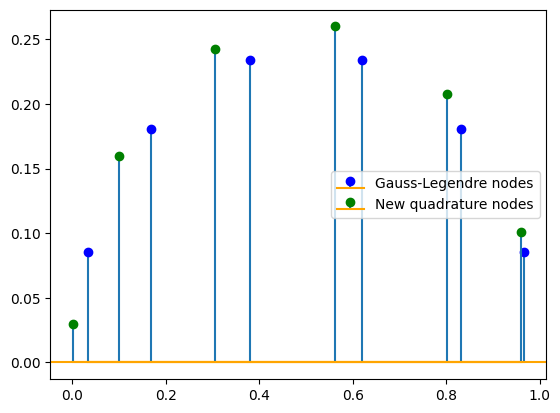

In [14]:
fig, ax = plt.subplots()
x_gl,w_gl = np.polynomial.legendre.leggauss(len(x))
w_gl = w_gl*0.5*I.length()
x_gl = I.translate(x_gl)
ax.axhline(y=0, c="orange")
ax.stem(x_gl, w_gl, markerfmt = 'bo', basefmt="orange", label=r"Gauss-Legendre nodes")
ax.stem(x, w, markerfmt = 'go', basefmt="orange", label=r"New quadrature nodes")
ax.legend()
print("Gauss-Legendre",np.around(x_gl,3))
print("New quadrature",np.around(sorted(x),3))

In [19]:
symx = sym.Symbol("x",real=True)
expr = symx**2
f = sym.lambdify(symx, expr, "numpy")
print("Gauss-Legendre error", abs(F.target_integral(expr) - f(x_gl)@w_gl))
print("New quadrature error", abs(F.target_integral(expr) - f(x)@w))


Gauss-Legendre error 5.55111512312578e-17
New quadrature error 3.43103680522372e-7


In [20]:
expr = 1/symx + symx**2
f = sym.lambdify(symx, expr, "numpy")
print("Gauss-Legendre error", abs(F.target_integral(expr) - f(x_gl)@w_gl))
print("New quadrature error", abs(F.target_integral(expr) - f(x)@w))

Gauss-Legendre error 15.8232659209464
New quadrature error 8.17209661008178e-6
